# Trial use of XGBoost


## Create simulated data

- Take Kaggle hotel customer satisfaction file: https://www.kaggle.com/datasets/michelhatab/hotel-reviews-bookingcom/code
- And Kaggle Booking.com customer comments file: https://www.kaggle.com/datasets/michelhatab/hotel-reviews-bookingcom/data


TO DO:
- Tidy up, generate scores
- XGBoost model evaluation, interpret results ... get SHAP to work and interpret
- Combine customer comments from other file
- Sentiment analysis



## Libraries and Functions

In [93]:
# Libraries
#

import os

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')  

In [94]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

# Tidy Up
del data_directory, project_directory

In [95]:
# A simple utility function to obtain and summarise key elements of a given dataframe

def print_file_summary(data_frame):
    # Create a temporary df and ensure no lists remain, so that unique items can be identified for uniqueness
    temp_df = data_frame.copy()
    temp_df = temp_df.map(lambda cell: str(cell) if isinstance(cell, list) else cell)
    
    # Calculate Data Types 
    summary_of_df = pd.DataFrame({'Count': data_frame.count(),
                                 'Missing': data_frame.isnull().sum(), 'Empty': 0,
                                 'Unique': temp_df.nunique(),
                                 'Type': data_frame.dtypes, 
                                 'String': 0, 'Int': 0, 'Float': 0, 'List': 0
                                 })
    summary_of_df['Empty'] = (data_frame == '').sum()
    summary_of_df['String'] = data_frame.map(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Int'] = data_frame.map(lambda cell: isinstance(cell, int)).sum()
    summary_of_df['Float'] = data_frame.map(lambda cell: isinstance(cell, float)).sum()
    summary_of_df['List'] = data_frame.map(lambda cell: isinstance(cell, list)).sum()

    display(summary_of_df)

## Files Load & Manipulate

In [96]:
# Load Source CSV files

# Read in the two original source files
file_name = 'booking_com_reviews.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')

hotel_reviews_df = pd.read_csv(file_path)

file_name = 'hotel_satisfaction_scores.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')

hotels_satisfaction_df = pd.read_csv(file_path)

# Tidy Up
del file_name, file_path

In [97]:
# Initial look at the data

print_file_summary(hotel_reviews_df)
hotel_reviews_df

print_file_summary(hotels_satisfaction_df)
hotels_satisfaction_df

,Count,Missing,Empty,Unique,Type,String,Int,Float,List
Title,1521,2,0,455,object,1521,0,2,0
PositiveReview,775,748,0,768,object,775,0,748,0
NegativeReview,434,1089,0,377,object,434,0,1089,0
Score,1523,0,0,12,float64,0,0,1523,0
GuestName,1523,0,0,1055,object,1523,0,0,0
GuestCountry,1523,0,0,68,object,1523,0,0,0
RoomType,1460,63,0,7,object,1460,0,63,0
NumberOfNights,1523,0,0,15,object,1523,0,0,0
VisitDate,1523,0,0,20,object,1523,0,0,0
GroupType,1523,0,0,4,object,1523,0,0,0


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
id,103904,0,0,103904,int64,0,103904,0,0
Gender,103904,0,0,2,object,103904,0,0,0
Age,103904,0,0,75,int64,0,103904,0,0
purpose_of_travel,103904,0,0,5,object,103904,0,0,0
Type of Travel,103904,0,0,2,object,103904,0,0,0
Type Of Booking,103904,0,0,3,object,103904,0,0,0
Hotel wifi service,103904,0,0,6,int64,0,103904,0,0
Departure_Arrival,103904,0,0,6,int64,0,103904,0,0
Ease of Online booking,103904,0,0,6,int64,0,103904,0,0
Hotel location,103904,0,0,6,int64,0,103904,0,0


,id,Gender,Age,purpose_of_travel,Type of Travel,Type Of Booking,Hotel wifi service,Departure_Arrival,Ease of Online booking,Hotel location,Food and drink,Stay comfort,Common Room entertainment,Checkin/Checkout service,Other service,Cleanliness,satisfaction
0,70172,Male,13,aviation,Personal Travel,Not defined,3,4,3,1,5,5,5,4,5,5,neutral or dissatisfied
1,5047,Male,25,tourism,Group Travel,Group bookings,3,2,3,3,1,1,1,1,4,1,neutral or dissatisfied
2,110028,Female,26,tourism,Group Travel,Group bookings,2,2,2,2,5,5,5,4,4,5,satisfied
3,24026,Female,25,tourism,Group Travel,Group bookings,2,5,5,5,2,2,2,1,4,2,neutral or dissatisfied
4,119299,Male,61,aviation,Group Travel,Group bookings,3,3,3,3,4,5,3,3,3,3,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,23,business,Group Travel,Individual/Couple,2,1,2,3,2,2,2,2,3,2,neutral or dissatisfied
103900,73097,Male,49,tourism,Group Travel,Group bookings,4,4,4,4,2,5,5,5,5,4,satisfied
103901,68825,Male,30,tourism,Group Travel,Group bookings,1,1,1,3,4,5,4,5,5,4,neutral or dissatisfied
103902,54173,Female,22,business,Group Travel,Individual/Couple,1,1,1,5,1,1,1,5,4,1,neutral or dissatisfied


In [98]:
# First Cut data for trial on XGBoost

# Function to generate partially random scores
import random
def gen_random(text_satisfaction ,cleanliness):
    if 'neutral or dissatisfied' in text_satisfaction:
        if cleanliness in [0,1]:
            return 0
        else:
            return random.randint(1,2)
    elif 'satisfied' in text_satisfaction:
        if cleanliness == 5:
            return 5
        else:
            return random.randint(3,4)
    else:
        return 5

# Copy a new df
hotels_satisfaction_new = hotels_satisfaction_df.copy()

# Fabricate an overall satisfaction score 0:5 based on the text satisfaction in source file
hotels_satisfaction_new['score_overall'] = hotels_satisfaction_new.apply(
            lambda row: gen_random(row['satisfaction'], row['Cleanliness']), axis=1)
hotels_satisfaction_new.drop('satisfaction', axis=1, inplace=True)

# Change column names for all scores
hotels_satisfaction_new.rename(columns={'Hotel wifi service': 'score_wifi',
                                        'Departure_Arrival': 'score_transport',
                                        'Ease of Online booking': 'score_booking',
                                        'Hotel location': 'score_location',
                                        'Food and drink': 'score_restaurant',
                                        'Stay comfort': 'score_spa',
                                        'Common Room entertainment': 'score_sports',
                                        'Checkin/Checkout service': 'score_checkin',
                                        'Other service': 'score_local_sites',
                                        'Cleanliness': 'score_housekeeping'
                                        }, 
                               inplace=True)

# Drop selected columns
columns = ['Age']
#columns = ['Gender', 'purpose_of_travel', 'Type of Travel', 'Type Of Booking']
hotels_satisfaction_new.drop(columns, axis=1, inplace=True)

# Check results
print_file_summary(hotels_satisfaction_new)
display(hotels_satisfaction_new)
display(hotels_satisfaction_new.describe())

# Save to CSV file
file_name = 'hotel_reviews.csv'
file_path = os.path.join(DATA_PATH, file_name)
hotels_satisfaction_new.to_csv(file_path, index=False)
print(f'Data saved to {file_path}')

# Tidy Up
del columns, file_name, file_path
del hotel_reviews_df, hotels_satisfaction_df, hotels_satisfaction_new


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
id,103904,0,0,103904,int64,0,103904,0,0
Gender,103904,0,0,2,object,103904,0,0,0
purpose_of_travel,103904,0,0,5,object,103904,0,0,0
Type of Travel,103904,0,0,2,object,103904,0,0,0
Type Of Booking,103904,0,0,3,object,103904,0,0,0
score_wifi,103904,0,0,6,int64,0,103904,0,0
score_transport,103904,0,0,6,int64,0,103904,0,0
score_booking,103904,0,0,6,int64,0,103904,0,0
score_location,103904,0,0,6,int64,0,103904,0,0
score_restaurant,103904,0,0,6,int64,0,103904,0,0


,id,Gender,purpose_of_travel,Type of Travel,Type Of Booking,score_wifi,score_transport,score_booking,score_location,score_restaurant,score_spa,score_sports,score_checkin,score_local_sites,score_housekeeping,score_overall
0,70172,Male,aviation,Personal Travel,Not defined,3,4,3,1,5,5,5,4,5,5,1
1,5047,Male,tourism,Group Travel,Group bookings,3,2,3,3,1,1,1,1,4,1,0
2,110028,Female,tourism,Group Travel,Group bookings,2,2,2,2,5,5,5,4,4,5,5
3,24026,Female,tourism,Group Travel,Group bookings,2,5,5,5,2,2,2,1,4,2,2
4,119299,Male,aviation,Group Travel,Group bookings,3,3,3,3,4,5,3,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,business,Group Travel,Individual/Couple,2,1,2,3,2,2,2,2,3,2,2
103900,73097,Male,tourism,Group Travel,Group bookings,4,4,4,4,2,5,5,5,5,4,4
103901,68825,Male,tourism,Group Travel,Group bookings,1,1,1,3,4,5,4,5,5,4,2
103902,54173,Female,business,Group Travel,Individual/Couple,1,1,1,5,1,1,1,5,4,1,0


,id,score_wifi,score_transport,score_booking,score_location,score_restaurant,score_spa,score_sports,score_checkin,score_local_sites,score_housekeeping,score_overall
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,64924.210502,2.729683,3.060296,2.756901,2.976883,3.202129,3.439396,3.358158,3.304290,3.640428,3.286351,2.411370
std,37463.812252,1.327829,1.525075,1.398929,1.277621,1.329533,1.319088,1.332991,1.265396,1.175663,1.312273,1.555395
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32533.750000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.000000
50%,64856.500000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,2.000000
75%,97368.250000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
max,129880.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Data saved to /Users/stuartgow/GitHub/Travel_Co_Analysis/Data_Sources/hotel_reviews.csv


## Model Creation & Evaluation


Categorical columns need to be converted into numerical columns before feeding into the model.

gender_mapping = {'Male': 0, 'Female': 1}
ad_data['Gender'] = ad_data['Gender'].map(gender_mapping)
ad_data['Gender'].value_counts(normalize=True)

# Use Label Encoding to convert 'country' to numerical feature
ad_data['Country'] = ad_data['Country'].astype('category').cat.codes
ad_data['Country'].value_counts()


In [99]:
# Read in the data file
file_name = 'hotel_reviews.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')

hotel_reviews_df = pd.read_csv(file_path)


# Convert categorical values for XGBoost
categorical_columns = ['Gender', 'purpose_of_travel','Type of Travel', 'Type Of Booking']
for next_col in categorical_columns:
    hotel_reviews_df[next_col] = hotel_reviews_df[next_col].astype('category')




print_file_summary(hotel_reviews_df)


# Tidy Up
del file_name, file_path

,Count,Missing,Empty,Unique,Type,String,Int,Float,List
id,103904,0,0,103904,int64,0,103904,0,0
Gender,103904,0,0,2,category,103904,0,0,0
purpose_of_travel,103904,0,0,5,category,103904,0,0,0
Type of Travel,103904,0,0,2,category,103904,0,0,0
Type Of Booking,103904,0,0,3,category,103904,0,0,0
score_wifi,103904,0,0,6,int64,0,103904,0,0
score_transport,103904,0,0,6,int64,0,103904,0,0
score_booking,103904,0,0,6,int64,0,103904,0,0
score_location,103904,0,0,6,int64,0,103904,0,0
score_restaurant,103904,0,0,6,int64,0,103904,0,0


In [100]:
# XGBoost Model Training

# Split the data into features X and target Y which is the customer satisfaction score

X = hotel_reviews_df.drop(columns=['id', 'score_overall'])
y = hotel_reviews_df['score_overall']

# Split the data randomly with 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model & fit to the data
model = xgb.XGBClassifier(enable_categorical=True)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2142
           1       0.47      0.47      0.47      4754
           2       0.48      0.49      0.49      4817
           3       0.47      0.51      0.49      3073
           4       0.48      0.41      0.44      3149
           5       0.96      0.98      0.97      2846

    accuracy                           0.59     20781
   macro avg       0.63      0.64      0.64     20781
weighted avg       0.59      0.59      0.59     20781

Classification Error: 0.41


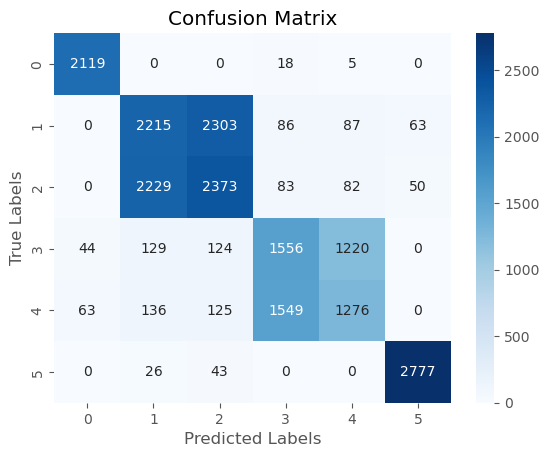

In [101]:

# Model Evaluation

from sklearn.metrics import classification_report
#from sklearn.metrics import precision_recall_curve, auc
#from sklearn.metrics import roc_curve, auc
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns


#from sklearn.metrics import accuracy_score

# Predictions
y_predictions = model.predict(X_test)
#y_pred_proba = model.predict_proba(X_test)[:, 1]


# Evaluation


# Classification report & accuracy score & Classification error - ?????
print(classification_report(y_test, y_predictions))
error = zero_one_loss(y_test, y_predictions)
print(f"Classification Error: {error:.2f}")

# Calculate and visualise the confusion matrix
cm = confusion_matrix(y_test, y_predictions)
#print("Confusion Matrix:")
#print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




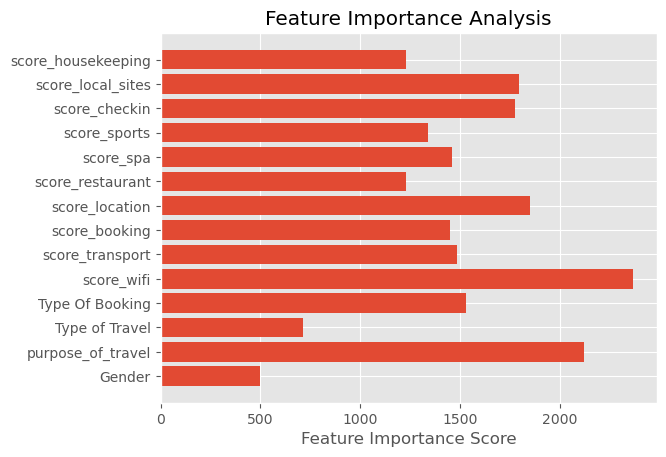

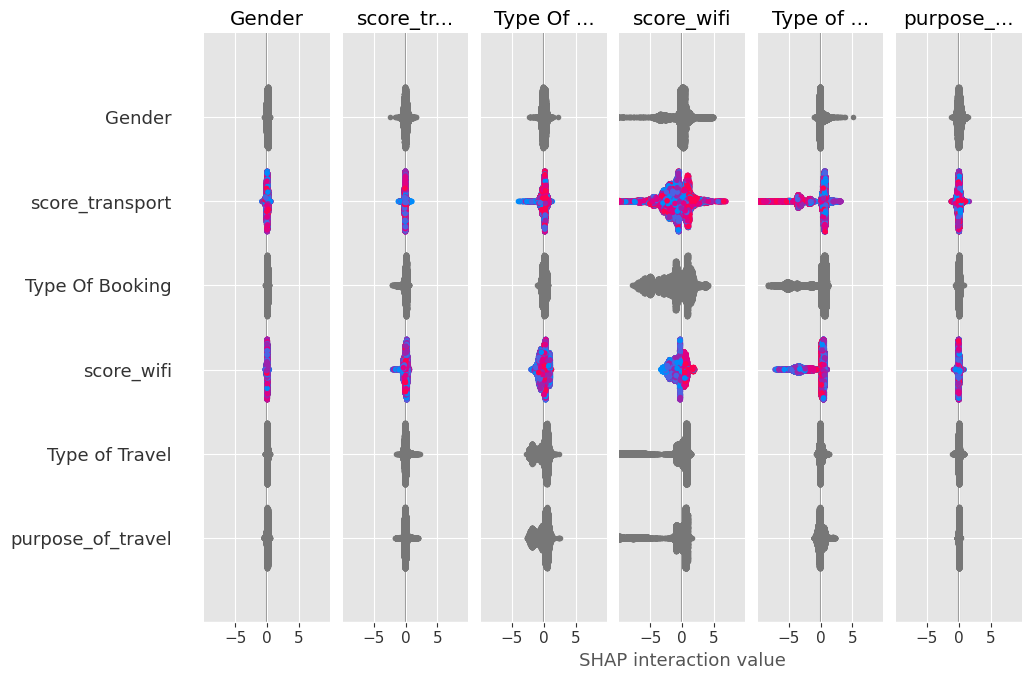

In [102]:
# Feature Importance
importance = model.get_booster().get_score(importance_type='weight')

plt.barh(list(importance.keys()), list(importance.values()))
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance Analysis')
plt.show()

# SHAP Feature importance
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

#shap.plots.bar(shap_values)


#shap.summary_plot(shap_values[0], X_test)




#shap_values_explanation = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test)
#shap.plots.waterfall(shap_values_explanation)

#shap.plots.waterfall(shap_values[0])

#expected_value = explainer.expected_value
#shap.decision_plot(expected_value, shap_values, X_test)


In [103]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Saving and Loading a trained model using the below code snippets.

model_new_hyper.save_model('model_new_hyper.model')
print("XGBoost model saved successfully.")
# Load the saved XGBoost model
import xgboost as xgb
loaded_model = xgb.Booster()
loaded_model.load_model('model_new_hyper.model')